## Install Tabnet library

In [1]:
import sys
sys.path.append("../input/tabnetdreamquark/tabnet-develop")

In [2]:
sys.path.append("../input/torch-sample/torchsample-master")

## Import required libraries

In [3]:
import os

import torch
import torchvision 
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import datatable as dt
import warnings
import random
warnings.filterwarnings('ignore')
pd.set_option('max_columns',None)
from sklearn.metrics import mean_squared_error

import PIL

from time import time
import pprint
import joblib
from functools import partial
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pytorch_tabnet.tab_model import TabNetRegressor

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from torchsample.modules import ModuleTrainer

## Defined global variables

In [5]:
data_dir = '../input/petfinder-pawpularity-score/'
working_dir = './'
global_batch_size = 32
workers = 2
seed = 42
model_name = 'resnet50_pretrained'
model_path = model_name
print(os.listdir(data_dir))
MAX_EPOCHS_TABNET = 1000

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']


In [6]:
# Defining a function to seed everything.
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

# Running the function:
seed_everything(seed)

## Import data

In [7]:
train_data = pd.read_csv(f'{data_dir}train.csv')
train_data.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [8]:
train_data.shape

(9912, 14)

In [9]:
train_data.isnull().sum()

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

In [10]:
train_copy = train_data.drop(["Pawpularity","Id"], axis = 1)
train_copy.head(3)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,0,1,1,1,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0


In [11]:
# https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#how-to-use-it
model = TabNetRegressor(n_d=16,
                       n_a=16,
                       n_steps=4,
                       gamma=1.9,
                       n_independent=4,
                       n_shared=5,
                       seed=seed,
                       optimizer_fn = torch.optim.Adam,
                       scheduler_params = {"milestones": [150,250,300,350,400,450],'gamma':0.2},
                       scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)

In [12]:
target = train_data["Pawpularity"]

In [13]:
# resouces: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    
    def __init__(self,patience,verbose,path,trace_func):
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.counter = -1
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.trace_func = trace_func
        
    def __call__(self,val_loss,model):
        
        if self.best_score is None:
            self.best_score = val_loss
            self.checkpoint(val_loss,model)
        
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.checkpoint(val_loss,model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        return self.path
    
    def checkpoint(self,val_loss,model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(),self.path)
        self.val_loss_min = val_loss

In [14]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [15]:
def rmse_fn(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    train_copy,target,
    test_size=0.1,
    random_state=42
)

In [17]:
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

In [18]:
def fit_pred_tabnet(X_train, y_train, X_val, random_state=42, max_epochs_tabnet=MAX_EPOCHS_TABNET):
    print("Fit tabnet")
    model.fit(X_train=X_train, y_train=y_train,eval_set=[(X_train, y_train), (X_val, y_val)],
                max_epochs=max_epochs_tabnet,batch_size=64,patience=100,
              eval_name=['train', 'valid'],eval_metric=['mae'],loss_fn=RMSELoss)
    print("Predict tabnet")
    pred_tabnet = model.predict(X_val)
    pred_tabnet = pred_tabnet.reshape(len(pred_tabnet))
    return pred_tabnet


In [19]:
pred_tabnet = fit_pred_tabnet(X_train, y_train, X_val)

Fit tabnet
epoch 0  | loss: 24.45757| train_mae: 14.99855| valid_mae: 15.40127|  0:00:10s
epoch 1  | loss: 20.6443 | train_mae: 16.25262| valid_mae: 16.53005|  0:00:18s
epoch 2  | loss: 20.61171| train_mae: 15.55471| valid_mae: 15.80931|  0:00:27s
epoch 3  | loss: 20.62026| train_mae: 15.65895| valid_mae: 15.90717|  0:00:36s
epoch 4  | loss: 20.5554 | train_mae: 14.9964 | valid_mae: 15.34733|  0:00:45s
epoch 5  | loss: 20.55784| train_mae: 15.12878| valid_mae: 15.45813|  0:00:54s
epoch 6  | loss: 20.51735| train_mae: 15.37586| valid_mae: 15.67332|  0:01:02s
epoch 7  | loss: 20.54107| train_mae: 15.05022| valid_mae: 15.33753|  0:01:11s
epoch 8  | loss: 20.46918| train_mae: 15.31591| valid_mae: 15.61565|  0:01:20s
epoch 9  | loss: 20.51496| train_mae: 15.63779| valid_mae: 15.92228|  0:01:29s
epoch 10 | loss: 20.53429| train_mae: 15.68811| valid_mae: 15.95786|  0:01:38s
epoch 11 | loss: 20.48771| train_mae: 15.17614| valid_mae: 15.50632|  0:01:47s
epoch 12 | loss: 20.4771 | train_mae: 15.

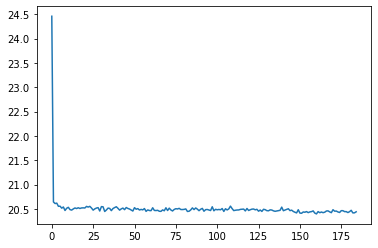

In [20]:
plt.plot(model.history['loss'])

In [21]:
rmse_tabnet = rmse_fn(pred_tabnet, y_val)
rmse_tabnet

21.07091557285329